# Task Information
## Goal

Submit automated predictions of lesion segmentation boundaries within dermoscopic images.

![Task 1 example segmentation boundaries](https://challenge2018.isic-archive.com/wp-content/uploads/2018/04/task1.png)

## Data
### Input Data

The input data consists of dermoscopic lesion images in JPEG format.

All lesion images are named using the scheme ISIC_<image_id>.jpg, where <image_id> is a 7-digit unique identifier. EXIF tags in the images have been removed; any remaining EXIF tags should not be relied upon to provide accurate metadata.

The lesion images were acquired with a variety of [dermatoscope types](https://dermoscopedia.org/Principles_of_dermoscopy), from all anatomic sites (excluding mucosa and nails), from a historical sample of patients presented for skin cancer screening, from several different institutions. Every lesion image contains exactly one primary lesion; other fiducial markers, smaller secondary lesions, or other pigmented regions may be neglected.

The distribution of disease states represent a modified “real world” setting whereby there are more benign lesions than malignant lesions, but an over-representation of malignancies.

### Response Data

The response data consists binary mask images in PNG format, indicating the location of the primary skin lesion within each input lesion image.

Mask images are named using the scheme ISIC_<image_id>_segmentation.png, where <image_id> matches the corresponding lesion image for the mask.

Mask images must have the exact same dimensions as their corresponding lesion image. Mask images are encoded as single-channel (grayscale) 8-bit PNGs (to provide lossless compression), where each pixel is either:

* 0: representing the background of the image, or areas outside the primary lesion
* 255: representing the foreground of the image, or areas inside the primary lesion

As the primary skin lesion is a single contiguous region, mask images should also contain only a single contiguous foreground region, without any disconnected components or holes. The foreground region may be of any size (including the entire image) and may abut the borders of the image.


### Ground Truth Provenance

Mask image ground truth (provided for training and used internally for scoring validation and test phases) data were generated using several techniques, but all data were reviewed and curated by practicing dermatologists with expertise in dermoscopy.

Ground truth segmentations were generated by either:

fully-automated algorithm, reviewed and accepted by a human expert
a semi-automated flood-fill algorithm, with parameters chosen by a human expert
manual polygon tracing by a human expert

In [28]:
import os, sys, random
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from skimage.transform import resize
from skimage.io import imread, imshow

### Read data

In [29]:
class load_dataset(keras.utils.Sequence):  
    def __init__(self, ids, path, batch_size=8, img_width=128, img_height=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size # Number of training samples at one time
        self.img_width = img_width # size of the pics
        self.img_height = img_height
        self.on_epoch_end()
        
    def __load__(self, id_name):
        # file path
        image_path = os.path.join(self.path, "images", id_name) + ".jpg" # train image
        mask_path = os.path.join(self.path, "masks", id_name) + "_segmentation.png" # segmentation image
        
        # Read the original image and the correctly segmented image separately
        train_image = imread(image_path) # Load color imgs
        train_image = resize(train_image, (self.img_width, self.img_height), mode='constant', preserve_range=True) # adjust size
        mask = np.zeros((self.img_width, self.img_height, 1), dtype=np.bool) # 128 * 128 * 1
        _mask = imread(mask_path) # cv2.IMREAD_UNCHANGED
        _mask = np.expand_dims(resize(_mask, (img_width, img_height), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, _mask) # Select maximum
        
        # normalize the images in range [0, 1]
        train_image = train_image / 255.0
        mask = mask / 255.0
        
        return train_image, mask
    
    def __getitem__(self, index):
        if(index + 1) * self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index * self.batch_size
        
        files_batch = self.ids[index * self.batch_size : (index + 1) * self.batch_size]
        
        train_image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            train_image.append(_img)
            mask.append(_mask)
            
        train_image = np.array(train_image)
        mask  = np.array(mask)
        
        return train_image, mask # Return array
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [30]:
# Set some parameters
img_width = 128 # 384
img_height = 128
img_channels = 3
path = "./dataset/ISIC2018_Task1-2_Training_Data/" 
train_path = "./dataset/ISIC2018_Task1-2_Training_Data/images" # Training set path
batch_size = 20

train_ids = []
for imgs in os.walk(train_path): # Traverse directory
   for id in imgs:
      train_ids.append(id)

train_ids = train_ids[2] # Get file name
train_ids = [i.split('.', 1)[0] for i in train_ids] # remove .jpg suffix

validation_data_size = 30 # Validation set size

valid_ids = train_ids[:validation_data_size]
train_ids = train_ids[validation_data_size:] # Data is divided into 2 parts

In [31]:
data = load_dataset(train_ids, path, batch_size=batch_size, img_width=img_width, img_height=img_height) # Read training pictures

x, y = data.__getitem__(0)
print(x.shape, y.shape)

(20, 128, 128, 3) (20, 128, 128, 1)


#### alternative way to get x_train and y_train, compare to above, just trial

In [ ]:
from tqdm import tqdm

image_ids = next(os.walk(train_path))[2]

X = np.zeros((len(image_ids), img_height, img_width, img_channels), dtype=np.uint8)
Y = np.zeros((len(image_ids), img_height, img_width, 1), dtype=np.bool)

for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):
    path = path
    img = imread(path + '/images/' + id_ )
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    X[n] = img
    mask = np.zeros((img_height, img_width, 1), dtype=np.bool)
    mask_ = imread(path + '/masks/' +  id_ )
    mask_ = np.expand_dims(resize(mask_, (img_height, img_width), mode='constant',
                                      preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)
    Y[n] = mask

x_train=X

y_train=Y

### Verify whether the image is successfully read

random number:  16


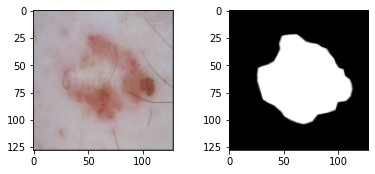

In [32]:
n = random.randint(0, len(x) - 1) # Random number within the number of pictures
print("random number: ", n)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4) # Adjust the page layout
ax = fig.add_subplot(1, 2, 1) # the first plot
ax.imshow(x[n])
ax = fig.add_subplot(1, 2, 2) # the sec plot
ax.imshow(np.reshape(y[n], (img_width, img_height)), cmap="gray")

In [33]:
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.layers import UpSampling2D, Concatenate

In [34]:
# Build U-Net model
# Note we make our layers varaibles so that we can concatenate or stack
# imput image tile
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = MaxPooling2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = UpSampling2D((2, 2))(x)
    concat = Concatenate()([us, skip])
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottom_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [35]:
def UNet():
    filter_size = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((img_width, img_height, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, filter_size[0]) 
    c2, p2 = down_block(p1, filter_size[1]) 
    c3, p3 = down_block(p2, filter_size[2])
    c4, p4 = down_block(p3, filter_size[3]) 
    
    bb = bottom_block(p4, filter_size[4])
    
    u1 = up_block(bb, c4, filter_size[3]) #8 -> 16
    u2 = up_block(u1, c3, filter_size[2]) #16 -> 32
    u3 = up_block(u2, c2, filter_size[1]) #32 -> 64
    u4 = up_block(u3, c1, filter_size[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_20[0][0]                  
_______________________________________________________________________________________

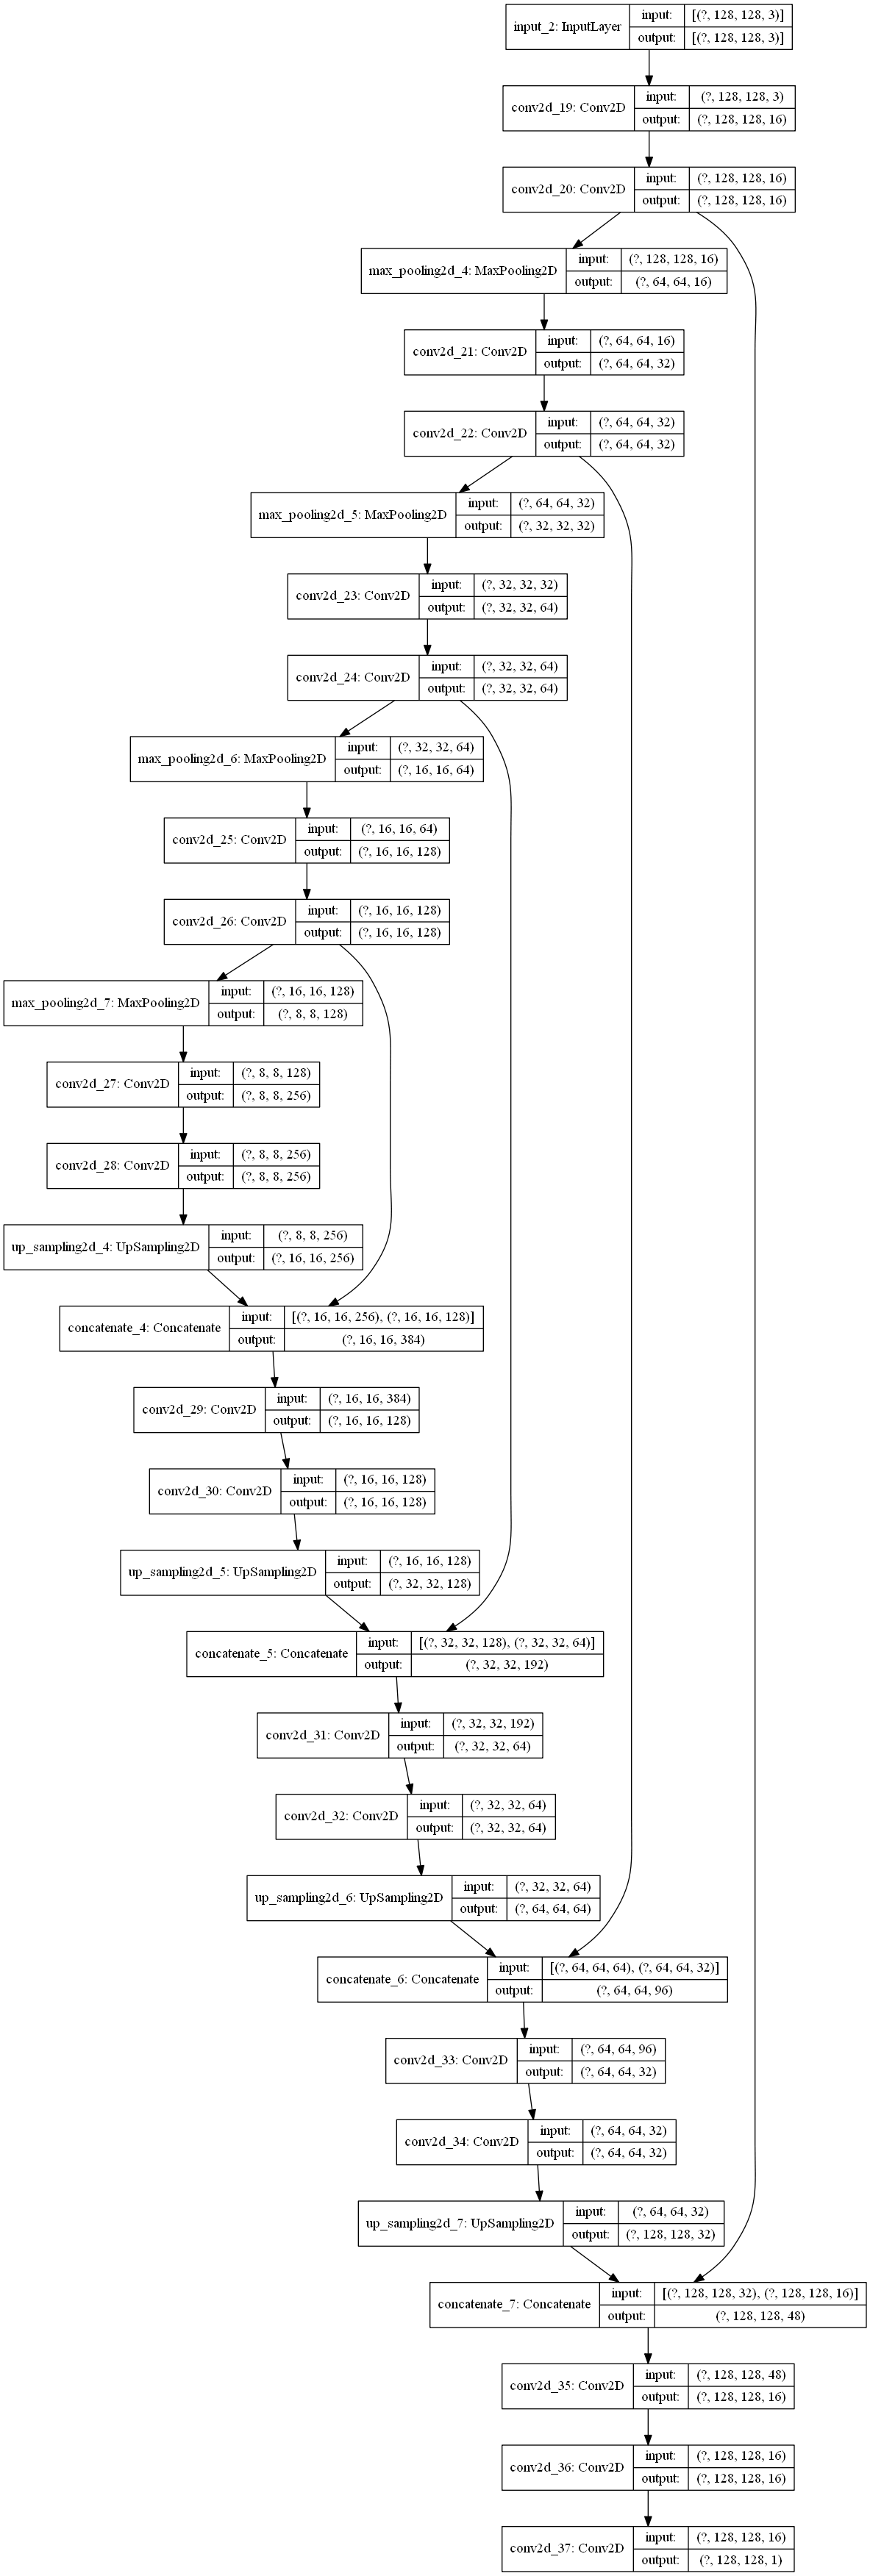

In [36]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])#优化器，损失函数，评估标准
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [40]:
train_gen = load_dataset(train_ids, path)
valid_gen = load_dataset(valid_ids, path, 3, 128)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

# Train the model by batch
model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs = 10)
model.save("U-Net_Model.h5") # Save model

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
128/128 [==============================] - 536s 4s/step - loss: 0.4695 - acc: 0.7579 - val_loss: 0.3846 - val_acc: 0.6873
Epoch 2/10
128/128 [==============================] - 415s 3s/step - loss: 0.3654 - acc: 0.7976 - val_loss: 0.2930 - val_acc: 0.8430
Epoch 3/10
128/128 [==============================] - 394s 3s/step - loss: 0.2996 - acc: 0.8211 - val_loss: 0.1544 - val_acc: 0.9109
Epoch 4/10
128/128 [==============================] - 417s 3s/step - loss: 0.2718 - acc: 0.8157 - val_loss: 0.1359 - val_acc: 0.9161
Epoch 5/10
128/128 [==============================] - 1391s 11s/step - loss: 0.2237 - acc: 0.8436 - val_loss: 0.1136 - val_acc: 0.9222
Epoch 6/10
128/128 [==============================] - 459s 4s/step - loss: 0.2702 - acc: 0.8152 - val_loss: 0.1538 - val_acc: 0.9108
Epoch 7/10
128/128 [==============================] - 388s 3s/step - loss: 0.2265 - acc: 0.8294 - val_loss: 0.0957 - val_acc

#### alternative way, compare to above, just trial

In [37]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0001, verbose=1)
]

In [39]:
history = model.fit(x_train, y_train, validation_split=0.1, batch_size=16, epochs=20,
                    callbacks=callbacks)

# history = model.fit(x, y, batch_size=32, epochs=10, callbacks = callbacks, steps_per_epoch=train_steps, 
#                     validation_steps=valid_steps, shuffle=True, validation_data=img_validate)

Epoch 1/20
2/2 [==============================] - 1s 345ms/step - loss: 0.6290 - acc: 0.6358 - val_loss: 0.6996 - val_acc: 0.3857
Epoch 2/20
2/2 [==============================] - 0s 133ms/step - loss: 0.6277 - acc: 0.6358 - val_loss: 0.7147 - val_acc: 0.3857
Epoch 3/20
2/2 [==============================] - 0s 131ms/step - loss: 0.6274 - acc: 0.6358 - val_loss: 0.7187 - val_acc: 0.3857
Epoch 4/20
2/2 [==============================] - ETA: 0s - loss: 0.6213 - acc: 0.6358
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2/2 [==============================] - 0s 134ms/step - loss: 0.6213 - acc: 0.6358 - val_loss: 0.7203 - val_acc: 0.3857
Epoch 5/20
2/2 [==============================] - 0s 141ms/step - loss: 0.6117 - acc: 0.6358 - val_loss: 0.7210 - val_acc: 0.3857
Epoch 6/20
2/2 [==============================] - 0s 132ms/step - loss: 0.6103 - acc: 0.6358 - val_loss: 0.7226 - val_acc: 0.3857
Epoch 7/20
2/2 [==============================] - ETA: 0s - los

### Make predictions
Let's make predictions both on the test set, the val set and the train set (as a sanity check). Generates output predictions for the input samples.\
note: Remember to load the best-saved model if you've used early stopping.
***return***: Numpy array(s) of predictions.

In [ ]:
# idea about how to calculate dice_coef
def dice_coef(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return (2. * intersection + 1.) / (torch.sum(y_true) + torch.sum(y_pred) + 1.)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

from keras import backend as K
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

# Loss funtion
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)